
# Parking **Occupancy** Detection

---


# **Parking Lot Database**

This database contains 12,417 images (1280X720) captured from two different parking lots (parking1 and parking2) in sunny, cloudy and rainy days. The first parking lot has two different capture angles (parking1a and parking 1b).

The images are organised into three directories (parking1a, parking1b and parking2). Each directory contains three subdirectories for different weather conditions (cloudy, rainy and sunny). Inside of each subdirectory the images are organised by acquisition date.

Each image of the database has a XML file associated including the coordinates of all the parking spaces and its label (occupied/vacant). By using the XML files to segment the parking space, you will be able to get around 695,900 images of parking spaces.

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
#You can use gdown if the file is shared publicly.
!gdown --id 1YIx4WukEKgjWQziherazcla2y7JuMsbP

Downloading...
From: https://drive.google.com/uc?id=1YIx4WukEKgjWQziherazcla2y7JuMsbP
To: /content/PKLot.tar.gz
4.90GB [01:31, 53.3MB/s]


In [4]:
! mkdir "/content/ParkingDataset/" 

In [5]:
!tar -xzvf "/content/PKLot.tar.gz" -C "/content/ParkingDataset/" 

Streaming output truncated to the last 5000 lines.
PKLot/PKLotSegmented/PUC/Sunny/2012-09-20/Occupied/2012-09-20_18_09_45#088.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-09-28/Occupied/2012-09-28_09_06_05#086.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-10-31/Occupied/2012-10-31_14_33_21#092.jpg
PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21/Occupied/2013-01-21_08_35_04#011.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-10-16/Empty/2012-10-16_06_26_44#050.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-09-28/Occupied/2012-09-28_11_06_11#047.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-17/Occupied/2012-09-17_10_59_02#100.jpg
PKLot/PKLotSegmented/UFPR05/Sunny/2013-03-10/Empty/2013-03-10_17_35_13#027.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-10-27/Empty/2012-10-27_12_15_53#018.jpg
PKLot/PKLotSegmented/PUC/Rainy/2012-09-21/Occupied/2012-09-21_11_45_24#077.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-20/Occupied/2012-09-20_17_34_43#052.jpg
PKLot/PKLotSegmented/UFPR05/Cloudy/2013-03-17/Empty/2013-03-17_15_20_10#033.jpg

In [6]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1381)

In [7]:
# Set the folders and its path to create train and validation split
# Model is trained on images from one parking lot and tested on another one

root_dir = "/content/ParkingDataset/PKLot/PKLotSegmented/"
classes = ["Empty", "Occupied"]

datasets = {
    "train": ["UFPR04/Sunny/", "UFPR04/Rainy/", "UFPR04/Cloudy/", "UFPR05/Sunny/", "UFPR05/Rainy/", "UFPR05/Cloudy/"],
    "valid": ["PUC/Sunny/","PUC/Rainy/", "PUC/Cloudy/"]
}

In [8]:
# Split the images into train and validation dataset and write the list as csv file
train_dataset = []
valid_dataset = []
                  
for c in classes:
    for data_type in datasets:
        for folder in datasets[data_type]:
            dir_content = [d for d in os.listdir(os.path.join(root_dir,folder)) if os.path.isdir(os.path.join(root_dir,folder,d))]
            #print(dir_content)
            for d in dir_content:
                folder_path = os.path.join(root_dir,folder,d, c)
                images = glob(os.path.join(folder_path, "*.jpg"))
                if len(images)>0:
                    if data_type == 'train':
                        sample_size = 0.3
                    else:
                        sample_size = 0.1
                    random_sample = np.random.choice(images, replace=False,size=int(len(images)*sample_size))
                    #print(len(random_sample))
                    for img in random_sample:
                        image_name = img.split("/")[-1]
                        temp = {}
                        temp['image_name'] = image_name
                        temp["label"] = c
                        temp['folder_path'] = os.path.join(folder,d)
                        temp['data_type'] = data_type
                        if data_type == 'train':
                            train_dataset.append(temp)
                        else:
                            valid_dataset.append(temp)

In [9]:
# convert the list into dataframe to store them as csv file
df_train = pd.DataFrame(train_dataset)
df_valid = pd.DataFrame(valid_dataset)

# shuffle the dataset
df_train = df_train.sample(frac=1, random_state=1431)
df_valid = df_valid.sample(frac=1, random_state=1431)

In [10]:
print(df_train)
print(df_valid)

                        image_name  ... data_type
75820  2013-03-13_12_15_07#039.jpg  ...     train
29303  2013-03-02_15_20_11#002.jpg  ...     train
21360  2013-03-03_16_20_12#035.jpg  ...     train
67242  2013-03-06_16_25_12#004.jpg  ...     train
61377  2013-02-23_13_55_08#031.jpg  ...     train
...                            ...  ...       ...
13348  2013-01-20_19_35_15#024.jpg  ...     train
36492  2013-03-15_07_05_01#020.jpg  ...     train
9848   2012-12-28_13_40_09#016.jpg  ...     train
30160  2013-03-06_06_40_00#034.jpg  ...     train
55212  2013-03-16_13_00_08#031.jpg  ...     train

[81406 rows x 4 columns]
                        image_name     label            folder_path data_type
39424  2012-10-16_14_58_46#006.jpg  Occupied  PUC/Cloudy/2012-10-16     valid
26136  2012-10-29_10_48_05#081.jpg  Occupied   PUC/Sunny/2012-10-29     valid
7062   2012-09-16_10_53_06#042.jpg     Empty   PUC/Sunny/2012-09-16     valid
13690  2012-11-09_13_11_50#001.jpg     Empty   PUC/Rainy/2012-

In [11]:
print("Train dataset size: ", df_train.shape)
print("Valid dataset size: ", df_valid.shape)

Train dataset size:  (81406, 4)
Valid dataset size:  (42384, 4)


In [12]:
def show_label_distribution(df):
    df_class = pd.DataFrame(df['label'].value_counts())
    df_class = df_class.reset_index()
    df_class = df_class.rename(columns={'index': 'label', 'label': 'count'})
    df_class['percentage'] = round((df_class['count'] / sum(df_class['count']))*100, 2)
    return df_class

In [13]:
train_df = show_label_distribution(df_train)
print("Train dataset ", train_df)
valid_df = show_label_distribution(df_valid)
print("Valid dataset ", valid_df)

Train dataset        label  count  percentage
0  Occupied  43027       52.85
1     Empty  38379       47.15
Valid dataset        label  count  percentage
0     Empty  22980       54.22
1  Occupied  19404       45.78


# Create index file for CNN-SVM **models**

---



In [15]:
!mkdir "/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/dataset_train.csv"
!mkdir "/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/dataset_valid.csv"
df_train.to_csv('dataset_train.csv', index=False)
df_valid.to_csv('dataset_valid.csv', index=False)

mkdir: cannot create directory ‘/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/dataset_train.csv’: No such file or directory
mkdir: cannot create directory ‘/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/dataset_valid.csv’: No such file or directory


In [16]:
df_train.head(3)

,image_name,label,folder_path,data_type
75820,2013-03-13_12_15_07#039.jpg,Occupied,UFPR05/Cloudy/2013-03-13,train
29303,2013-03-02_15_20_11#002.jpg,Empty,UFPR05/Sunny/2013-03-02,train
21360,2013-03-03_16_20_12#035.jpg,Empty,UFPR05/Sunny/2013-03-03,train


In [17]:
df_valid.head(3)

,image_name,label,folder_path,data_type
39424,2012-10-16_14_58_46#006.jpg,Occupied,PUC/Cloudy/2012-10-16,valid
26136,2012-10-29_10_48_05#081.jpg,Occupied,PUC/Sunny/2012-10-29,valid
7062,2012-09-16_10_53_06#042.jpg,Empty,PUC/Sunny/2012-09-16,valid


# Create train and valid dataset for CNN **models**

---



In [18]:
import pandas as pd
import os
from shutil import copy2

In [19]:
!mkdir "/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/"
df_train = pd.read_csv("dataset_train.csv")
df_valid = pd.read_csv("dataset_valid.csv")

In [20]:
!mkdir "/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/"
cnn_dataset = "/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/"

if not os.path.isdir(cnn_dataset):
    os.makedirs(cnn_dataset)
    print('CNN dataset folder created at ', cnn_dataset)

Create sample datataset. To create full train and valid dataset set the sample size to 100000 (size greater than number of images in df_train and df_valid to include all the images)

In [21]:
# set sample size to create sample dataset
train_sample_size = 5000
valid_sample_size = 500

# Copy train **dataset**

In [22]:
if not os.path.isdir(os.path.join(cnn_dataset, 'train', 'Occupied')):
    os.makedirs(os.path.join(cnn_dataset, 'train', 'Occupied'))
    print('train/Occupied folder created at ', cnn_dataset)

if not os.path.isdir(os.path.join(cnn_dataset, 'train', 'Empty')):
    os.makedirs(os.path.join(cnn_dataset, 'train', 'Empty'))
    print('train/Empty folder created at ', cnn_dataset)

count = 1
for idx in df_train.index.values[:train_sample_size]:
    src = os.path.join(root_dir, df_train.loc[idx, 'folder_path'], df_train.loc[idx, 'label'], df_train.loc[idx, 'image_name'])
    if df_train.loc[idx, 'label'] == 'Occupied':
        dst = os.path.join(cnn_dataset, 'train', 'Occupied')
    else:
        dst = os.path.join(cnn_dataset, 'train', 'Empty')
        
    copy2(src, dst)
    count+=1

print("Total train images:", count)

train/Occupied folder created at  /content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/
train/Empty folder created at  /content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/
Total train images: 5001


# Copy valid **dataset**

In [23]:
if not os.path.isdir(os.path.join(cnn_dataset, 'valid', 'Occupied')):
    os.makedirs(os.path.join(cnn_dataset, 'valid', 'Occupied'))
    print('valid/Occupied folder created at ', cnn_dataset)

if not os.path.isdir(os.path.join(cnn_dataset, 'valid', 'Empty')):
    os.makedirs(os.path.join(cnn_dataset, 'valid', 'Empty'))
    print('valid/Empty folder created at ', cnn_dataset)

count = 1
for idx in df_valid.index.values[:valid_sample_size]:
    src = os.path.join(root_dir, df_valid.loc[idx, 'folder_path'], df_valid.loc[idx, 'label'], df_valid.loc[idx, 'image_name'])
    if df_valid.loc[idx, 'label'] == 'Occupied':
        dst = os.path.join(cnn_dataset, 'valid', 'Occupied')
    else:
        dst = os.path.join(cnn_dataset, 'valid', 'Empty')
        
    copy2(src, dst)
    count+=1
    
print("Total valid images:", count)

valid/Occupied folder created at  /content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/
valid/Empty folder created at  /content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/
Total valid images: 501


# **cnn_models_resnet50**

Train and validate the ResNet-50 model in PKLot dataset. 


In [25]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Instantiate the base model to extract features
HEIGHT = 49
WIDTH = 37

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [29]:
TRAIN_DIR = "/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/train/"
BATCH_SIZE = 32

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                   class_mode='binary')

Found 5000 images belonging to 2 classes.


In [30]:
VALID_DIR = "/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/"
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_generator = valid_datagen.flow_from_directory(
        VALID_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 500 images belonging to 2 classes.


In [31]:
print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 49, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 55, 43, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 19, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 19, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [32]:
# Freeze the base model not to train
for layer in base_model.layers:
        layer.trainable = False

In [33]:
# Define the top layers to do classifiction
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(1, activation='sigmoid')(x)

tf_model = Model(inputs=base_model.input, outputs=pred)

In [34]:
print(tf_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 49, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 55, 43, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 19, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 19, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [35]:
# choose the optimizers that works well with the dataset
tf_model.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

# tf_model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [36]:
# Set the number of train and validation examples, epochs and bact size

# # To train on full dataset, please uncomment this and comment sample dataset 
# nb_train_samples = 81406
# nb_validation_samples = 42384
# batch_size =  BATCH_SIZE

# To train on sample dataset
nb_train_samples = 5000
nb_validation_samples = 500
batch_size =  8
epochs = 10

In [37]:
# Fine-tune the top layers
tf_hist = tf_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs
        )

Epoch 1/10
157/157 [==============================] - 64s 387ms/step - loss: 0.2416 - accuracy: 0.9154 - val_loss: 0.6893 - val_accuracy: 0.4560
Epoch 2/10
157/157 [==============================] - 60s 383ms/step - loss: 0.1175 - accuracy: 0.9642 - val_loss: 0.6886 - val_accuracy: 0.4460
Epoch 3/10
157/157 [==============================] - 60s 381ms/step - loss: 0.1052 - accuracy: 0.9654 - val_loss: 0.6874 - val_accuracy: 0.4800
Epoch 4/10
157/157 [==============================] - 59s 378ms/step - loss: 0.0820 - accuracy: 0.9732 - val_loss: 0.6867 - val_accuracy: 0.5520
Epoch 5/10
157/157 [==============================] - 60s 379ms/step - loss: 0.0779 - accuracy: 0.9714 - val_loss: 0.6860 - val_accuracy: 0.6440
Epoch 6/10
157/157 [==============================] - 60s 380ms/step - loss: 0.0663 - accuracy: 0.9760 - val_loss: 0.6858 - val_accuracy: 0.6300
Epoch 7/10
157/157 [==============================] - 64s 406ms/step - loss: 0.0638 - accuracy: 0.9768 - val_loss: 0.6856 - val_ac

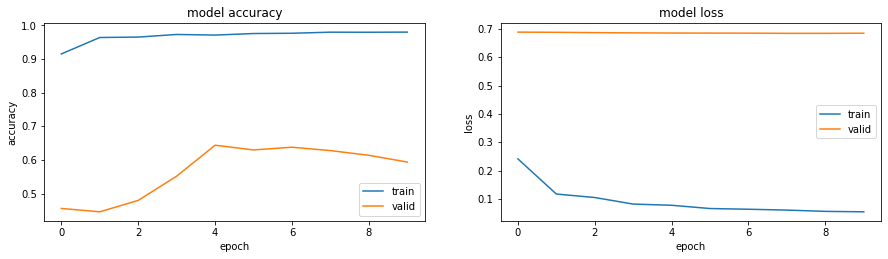

In [38]:
plt.figure(figsize = (15,8)) 
plt.subplot(2,2,1)  
plt.plot(tf_hist.history['accuracy'])  
plt.plot(tf_hist.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(tf_hist.history['loss'])  
plt.plot(tf_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

# Model prediction on validation **dataset**

---



In [39]:
from glob import glob
import numpy as np
!pip install utils
from utils import *
import cv2

In [40]:
occupied_dir = "/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Occupied/*.jpg"
empty_dir = "/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Empty/*.jpg"

valid_images = glob(occupied_dir) + glob(empty_dir)

In [41]:
print(valid_images)

['/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Occupied/2012-09-13_11_00_19#052.jpg', '/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Occupied/2012-09-14_10_36_14#072.jpg', '/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Occupied/2012-09-12_07_49_42#010.jpg', '/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Occupied/2012-09-14_14_26_24#020.jpg', '/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Occupied/2012-09-21_15_40_34#070.jpg', '/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Occupied/2012-09-15_16_42_25#060.jpg', '/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Occupied/2012-09-14_10_06_13#067.jpg', '/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn_dataset/valid/Occupied/2012-11-08_09_30_33#072.jpg', '/content/ParkingDataset/PKLot/PKLotSegmented/pklot_dataset/cnn

In [42]:
valid_sample_size = 250 # To run  on complete valid dataset. Please set this to 50000 (value greater than number of valid images)
valid_images = list(valid_images)
np.random.shuffle(valid_images)
valid_images = valid_images[:valid_sample_size]

In [43]:
HEIGHT = 49
WIDTH = 37

In [47]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from keras.preprocessing import image

ground_truth = []
prediction = []
for img in valid_images:
    label = img.split("/")[-2]
    if label == "Occupied":
        ground_truth.append(1)
    else:
        ground_truth.append(0)

    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(images=img, size=(HEIGHT, WIDTH))
    image_x = np.expand_dims(img, axis=0)

    pred = tf_model.predict(image_x)
    pred = np.squeeze(pred)
    if pred > 0.98:
        prediction.append(1)
    else:
        prediction.append(0)

# Validate the **model**

---



In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [49]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [50]:
# Show the classification metrics
print(classification_report(ground_truth, prediction, target_names=['Empty', 'Occupied']))

              precision    recall  f1-score   support

       Empty       0.52      1.00      0.68       130
    Occupied       0.00      0.00      0.00       120

    accuracy                           0.52       250
   macro avg       0.26      0.50      0.34       250
weighted avg       0.27      0.52      0.36       250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


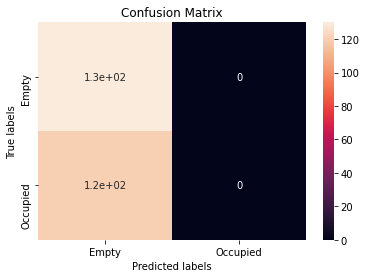

In [51]:
# confusion matrix
cm = confusion_matrix(ground_truth, prediction)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Empty', 'Occupied']); 
ax.yaxis.set_ticklabels(['Empty', 'Occupied']);

In [52]:
print("Confusion matrix")
print(cm)

Confusion matrix
[[130   0]
 [120   0]]
